In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

path = os.path.join(os.path.join(os.getcwd(), os.pardir),"data")
print(path)
file = os.path.join(path, "skylab_instagram_datathon_dataset.csv")
file= '../../data-20240427T110720Z-001\data\skylab_instagram_datathon_dataset.csv'
data = pd.read_csv(file, delimiter=";")

f:\Documents\Python Scripts\Datathon\datathon\src\..\data


# 1. Data Cleaning & Exploration

The data includes a lot of NaN values. We considered several approaches of dealing with such values and settled on linear interpolation. In that way, the general trends in the data are preserved and we don't throw away any useful data. Additionally, there often occurs the case, that there are NaN values at the beginning and the end of the time series data. In this case, we decided to throw away these datapoints, since it's hard to interpolate the ends without disturbing the general statistics of the data.

In [25]:
# Assuming 'data' is your DataFrame and 'metrics' is a list of columns to interpolate
def clean_dataframe(data, metrics, method: str="linear"):
    data = data.sort_values("period_end_date")
    companies = data["business_entity_doing_business_as_name"].unique()
    new = [None]*len(companies) 
    # Group by the company name and apply interpolation within each group
    for i in range(len(companies)):
        company = companies[i]
        company_idx = (data["business_entity_doing_business_as_name"] == company)
        filtered = data[company_idx]
        filtered[metrics] = filtered[metrics].interpolate(method=method)
        filtered = filtered.dropna()
        new[i] = filtered

    new_data = pd.concat(new, ignore_index=True)
    return new_data.sort_values("period_end_date")

data["period_end_date"] = pd.to_datetime(data["period_end_date"])

metrics = ["followers", "pictures", "likes", "videos", "comments"]
data = clean_dataframe(data, metrics)

C:\Users\Elias\AppData\Local\Temp\ipykernel_2736\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_2736\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered[metrics] = filtered[metrics].interpolate(method=method)
C:\Users\Elias\AppData\Local\Temp\ipykernel_2736\2127425605.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

## Data Counts

number companies:  52


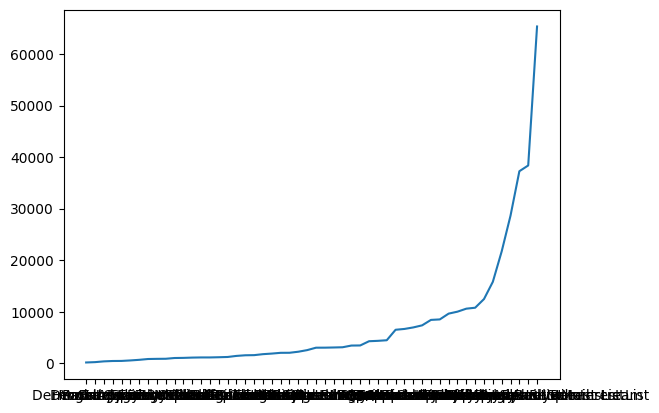

                                     entries   na
Global Luxury Analysts Interest List   21704  NaN
Beauty & Boutique                      28649  NaN
Apparel Retail                         37265  NaN
Luxury & Premium & Mainstream          38382  NaN
US Softlines Analyst Interest List     65354  NaN


In [26]:
import matplotlib.pyplot as plt

def count_entries(data: pd.DataFrame, column: str):
    cats = list(set(list(data["compset"])))
    print("number companies: ", len(cats))

    table = pd.DataFrame(columns=["entries", "na"], index=cats)
    for company in cats:
        data_company = data[data["compset"] == company]
        table.loc[company, "entries"] = len(data_company)
    table = table.sort_values(by=["entries"])
    return table

table = count_entries(data=data, column="compset")
plt.plot(table["entries"])
plt.show()
print(table[-5:])

## Yearly Means

C:\Users\Elias\AppData\Local\Temp\ipykernel_2736\2124670848.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year


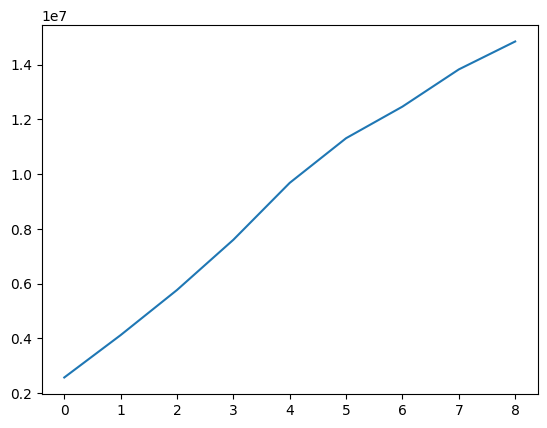

In [27]:
def calculate_yearly_means(df, col, category_column, category_value, period: str="yearly"):
    filtered_df = df[df[category_column] == category_value]
    
    # Convert the index to datetime if it's not already
    if period == "yearly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.year
    elif period == "montly":
        filtered_df["time"] = pd.to_datetime(filtered_df["period_end_date"]).dt.month

    yearly_means = filtered_df[col].groupby(filtered_df["time"]).mean()
    
    return yearly_means

yearly_means = calculate_yearly_means(data, "followers", "compset", "Soft Luxury", period="yearly")
plt.plot(range(len(yearly_means)), yearly_means)

# 2. Enrichment

To be able to work with more relevant data, we decided to transform our raw data into widely used marketing measures, which better represent the engagement of the  customer with companies social media presence. To this end we employ the following metrics:
Sure, here's a concise bullet point list of the calculated measures and their relevance:

1. **Average Engagement per Post**:
   - **Relevance**: Provides insight into the average engagement (likes and comments) received per post, considering both pictures and videos.
   - **Formula**: Calculated as the total likes and comments divided by the total number of posts (pictures and videos), adjusted to avoid division by zero.

2. **Engagement Rate**:
   - **Relevance**: Measures the level of engagement relative to the number of followers, indicating how well the content resonates with the audience.
   - **Formula**: Calculated as the total likes and comments divided by the total number of followers, multiplied by 100 to express as a percentage.

3. **Average Likes per Post** and **Average Comments per Post**:
   - **Relevance**: Provides separate insights into the average number of likes and comments received per post, aiding in understanding audience preferences.
   - **Formula**: Likes and comments divided by the total number of posts (pictures and videos), adjusted to avoid division by zero.

4. **Growth Coefficients**:
   - **Relevance**: Measures the relative growth of followers and its distribution per post and per engagement, indicating the effectiveness of content in attracting new followers.
   - **Formulas**: 
     - Relative Growth: Change in followers relative to the total number of followers.
     - Growth per Post: Relative growth divided by the total number of posts.
     - Growth per Engagement: Relative growth divided by the total likes and comments, adjusted to avoid division by zero.

5. **Virality Coefficients**:
   - **Relevance**: Assess the virality of content based on the type of media (pictures vs. videos) and their combined effect on follower growth.
   - **Formulas**: 
     - Video Engagement and Picture Engagement: Ratio of videos or pictures to total followers.
     - Picture Virality and Video Virality: Product of engagement ratio and relative growth, indicating the impact of each media type on follower growth.

These measures collectively offer a comprehensive and exhaustive understanding of social media performance, engagement effectiveness, and content virality for the analyzed companies. This provides a good base for later analysis and the selection of especially relevant and extraordinary features.



In [37]:
""" # Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

features = ['average_engagement_per_post', 'engagement_rate', 'average_likes_per_post', 
                'average_comments_per_post', 'growth_per_post', 'growth_per_engagement',
                'video_virality', 'picture_virality']
# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    weekly_data["followers_delta"] = weekly_data["followers"].diff().fillna(0)

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / weekly_data['followers'] * 100
    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate growth coefficients 
    weekly_data['relative_growth'] = weekly_data['followers_delta']/weekly_data['followers']
    weekly_data['growth_per_post'] = (weekly_data['relative_growth'])/(weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['growth_per_engagement'] = (weekly_data['relative_growth'])/(weekly_data['likes'] + weekly_data['comments']+0.001)

    #calculate virality coefficients
    weekly_data['video_engagement'] = (weekly_data['videos']/weekly_data['followers'])
    weekly_data['picture_engagement'] = (weekly_data['pictures']/weekly_data['followers'])
    weekly_data['picture_virality'] = weekly_data['picture_engagement']*weekly_data['relative_growth']
    weekly_data['video_virality'] = weekly_data['video_engagement']*weekly_data['relative_growth']
    

    # Calculate the like-to-comment ratio for each week
    # I actually think this feature does not make sense
    #weekly_data['like_to_comment_ratio'] = weekly_data['likes'] / (weekly_data['comments'] + 0.001)


    # Calculate the virality rate for each week
    # Virality rate = (engagement per post this week / average engagement per post baseline) * 100
    # weekly_data['virality_rate'] = (weekly_data['average_engagement_per_post'] / weekly_data['average_engagement_per_post'].mean()) * 100
    

    # Merge the calculated weekly metrics back to the original dataframe
    df = pd.merge(df, weekly_data[['period_end_date'] + features], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df

# Optionally, to check the results for a specific company, e.g., 'Nike'
nike_data = company_tables['Nike']
print(nike_data.head())
 """

#Sort the data by company name and period end date
impute_test = data.sort_values(by=['business_entity_doing_business_as_name', 'period_end_date'])

features = ['followers_delta', 'followers_second_delta',
       'followers_spike', 'average_engagement_per_post',
       'like_to_comment_ratio', 'per_post_aquisition', 'engagement_rate',
       'relative_growth', 'growth_per_post',
       'growth_per_engagement', 'video_by_followers', 'picture_by_followers',
       'picture_virality_index', 'video_virality_index', "virality_index"]

# Group the data by company name
grouped = impute_test.groupby('business_entity_doing_business_as_name')

# For each company, process the data to handle duplicates and compset variations
company_tables = {}
for name, group in grouped:
    # Drop the company name column as it's redundant in individual company dataframes
    group = group.drop(columns='business_entity_doing_business_as_name')
    group.drop_duplicates()
    
    # Group by period_end_date and aggregate
    group = group.groupby('period_end_date').agg({
        'compset': lambda x: list(set(x)),  # Convert compset values to a set to remove duplicates, then to a list
        'followers': 'mean',  # Assuming followers should be averaged
        'pictures': 'sum',  # Summing up the pictures
        'videos': 'sum',    # Summing up the videos
        'comments': 'sum',  # Summing up the comments
        'likes': 'sum'      # Summing up the likes
    }).reset_index()

    # Store the processed DataFrame back to the company_tables dictionary
    company_tables[name] = group


# Iterate over each company in the company_tables
for company, df in company_tables.items():
    # Ensure the data is sorted by date - assuming 'period_end_date' is the weekly identifier
    df = df.sort_values(by='period_end_date')

    # Group by 'period_end_date' to handle data week by week
    weekly_data = df.groupby('period_end_date').agg({
        'likes': 'sum',
        'comments': 'sum',
        'followers': 'mean',  # Assuming 'followers' is stable across the week, we take the mean
        'pictures': 'sum',    # Summing up the number of pictures
        'videos': 'sum'       # Summing up the number of videos
    }).reset_index()

    weekly_data["followers_delta"] = weekly_data["followers"].diff().fillna(0)
    weekly_data["followers_second_delta"] = weekly_data["followers_delta"].diff().fillna(0)

    weekly_data["followers_spike"] = ((weekly_data["followers_delta"] - weekly_data["followers_delta"].median()).abs() > weekly_data["followers_delta"].std()).astype(int)

    # Calculate the average engagement per post for the baseline
    weekly_data['average_engagement_per_post'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate like to comment ratio
    weekly_data['like_to_comment_ratio'] = (weekly_data['likes'] / (weekly_data['comments'] + 0.001))

    # Calculate per post aquisition
    weekly_data['per_post_aquisition'] = weekly_data["followers_delta"] / (weekly_data['likes'] + weekly_data['comments'] + 0.001)

    # Calculate the engagement rate for each week
    weekly_data['engagement_rate'] = (weekly_data['likes'] + weekly_data['comments']) / (weekly_data['followers'] + 0.001)
    weekly_data['picture_engagement'] = (weekly_data['pictures']) / (weekly_data['followers'] + 0.001)
    weekly_data['video_engagement'] = (weekly_data['videos']) / (weekly_data['followers'] + 0.001)

    # Calculate the average likes and comments per post for each week
    weekly_data['average_likes_per_post'] = weekly_data['likes'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['average_comments_per_post'] = weekly_data['comments'] / (weekly_data['pictures'] + weekly_data['videos'] + 0.001)

    # Calculate growth coefficients 
    weekly_data['relative_growth'] = weekly_data['followers_delta']/(weekly_data['followers'] + 0.001)
    weekly_data['growth_per_post'] = (weekly_data['relative_growth'])/(weekly_data['pictures'] + weekly_data['videos'] + 0.001)
    weekly_data['growth_per_engagement'] = (weekly_data['relative_growth'])/(weekly_data['likes'] + weekly_data['comments']+0.001)

    #calculate virality coefficients
    weekly_data['video_by_followers'] = (weekly_data['videos']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_by_followers'] = (weekly_data['pictures']/(weekly_data['followers'] + 0.001))
    weekly_data['picture_virality_index'] = weekly_data['picture_engagement']*weekly_data['relative_growth']
    weekly_data['video_virality_index'] = weekly_data['video_engagement']*weekly_data['relative_growth']
    weekly_data["virality_index"] = weekly_data['picture_virality_index'] + weekly_data['video_virality_index']
    

    # Calculate the like-to-comment ratio for each week
    # I actually think this feature does not make sense
    #weekly_data['like_to_comment_ratio'] = weekly_data['likes'] / (weekly_data['comments'] + 0.001)

    # Calculate the virality rate for each week
    # Virality rate = (engagement per post this week / average engagement per post baseline) * 100
    # weekly_data['virality_rate'] = (weekly_data['average_engagement_per_post'] / weekly_data['average_engagement_per_post'].mean()) * 100
    
    # Merge the calculated weekly metrics back to the original dataframe
    df = pd.merge(df, weekly_data[['period_end_date'] + features], on='period_end_date', how='left')
    df["business_entity_doing_business_as_name"] = [company]*len(df)
    # Update the company_tables dictionary with the modified DataFrame
    company_tables[company] = df

# Optionally, to check the results for a specific company, e.g., 'Nike'
nike_data = company_tables['Nike']
print(nike_data.head())

  period_end_date                                            compset  \
0      2015-01-10  [US Softlines Analyst Interest List, Sportswea...   
1      2015-01-17  [Sportswear, US Softlines Analyst Interest Lis...   
2      2015-01-24  [US Softlines Analyst Interest List, Sportswea...   
3      2015-01-31  [US Softlines Analyst Interest List, Sportswea...   
4      2015-02-07  [US Softlines Analyst Interest List, Sportswea...   

    followers  pictures  videos  comments       likes  followers_delta  \
0  25299746.0     465.0     3.0  321669.0  39738612.0              0.0   
1  26143731.0     471.0     9.0  393432.0  43148382.0         843985.0   
2  26851899.0     447.0     9.0  383376.0  40263060.0         708168.0   
3  27483940.0     399.0     9.0  411510.0  36760893.0         632041.0   
4  28077326.0     423.0     6.0  444420.0  36223413.0         593386.0   

   followers_second_delta  followers_spike  ...  average_comments_per_post  \
0                     0.0                1  

In [29]:
enriched_data = pd.concat(company_tables.values(), ignore_index=True)

company_tables.keys()
enriched_data.head()

,period_end_date,compset,followers,pictures,videos,comments,likes,followers_delta,followers_second_delta,followers_spike,...,engagement_rate,relative_growth,growth_per_post,growth_per_engagement,video_by_followers,picture_by_followers,picture_virality_index,video_virality_index,virality_index,business_entity_doing_business_as_name
0,2017-09-23,"[Ecommerce Apparel Retail, Apparel Retail, US ...",19140.0,300.0,40.0,784.0,75412.0,0.0,0.0,0,...,3.980982,0.000000,0.000000,0.000000e+00,0.002090,0.015674,0.000000,0.000000,0.000000,24S
1,2017-09-30,"[Ecommerce Apparel Retail, Apparel Retail, US ...",20089.0,260.0,52.0,748.0,71020.0,949.0,949.0,0,...,3.572502,0.047240,0.000151,6.582290e-07,0.002588,0.012942,0.000611,0.000122,0.000734,24S
2,2017-10-07,"[Ecommerce Apparel Retail, Apparel Retail, US ...",21007.0,220.0,48.0,576.0,62932.0,918.0,-31.0,0,...,3.023183,0.043700,0.000163,6.880978e-07,0.002285,0.010473,0.000458,0.000100,0.000558,24S
3,2017-10-14,"[Ecommerce Apparel Retail, Apparel Retail, US ...",22034.0,184.0,52.0,472.0,59208.0,1027.0,109.0,0,...,2.708541,0.046610,0.000197,7.809950e-07,0.002360,0.008351,0.000389,0.000110,0.000499,24S
4,2017-10-21,"[Ecommerce Apparel Retail, Apparel Retail, US ...",22425.0,184.0,40.0,476.0,57800.0,391.0,-636.0,0,...,2.598707,0.017436,0.000078,2.991951e-07,0.001784,0.008205,0.000143,0.000031,0.000174,24S


# 3. Modelling


In [35]:
def average_table(df, category_column, interesting_period, features, period: str="yearly"):
    cats = df[category_column].unique()
    table = pd.DataFrame(columns=features, index=cats)
    
    if period == "yearly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.year
    elif period == "monthly":
        df["time"] = pd.to_datetime(df["period_end_date"]).dt.month

    df = df[df["time"] == interesting_period]

    for cat in cats:
        df_cat = df[df[category_column] == cat]
        for col in features:
            table.loc[cat, col] = np.nanmean(df_cat[col])
     
    return table.dropna() #?? 


table = average_table(enriched_data, "business_entity_doing_business_as_name", 2023, features)
print(table.head())

KeyError: 'average_comments_per_post'

We need to first scale our dataframe to ensure that no feature weighs too much compared to others and skew the centroids of our kmeans

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

table_scaled = pd.DataFrame(scaler.fit_transform(table), columns = table.columns, index = table.index )

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def kmeans_silhouette_scores(df):
    silhouette_scores = []

    # Example using the same dataset as above
    for i in range(2, 11):  # Silhouette score cannot be computed with only one cluster
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        score = silhouette_score(df, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores

relevant_features = ['followers_delta', 'followers_second_delta', 'followers_spike', 'average_engagement_per_post',
 'per_post_aquisition', 'engagement_rate', 'relative_growth', 'growth_per_post', 'growth_per_engagement',
 'virality_index']
rel_table = table_scaled[relevant_features]
rel_table = rel_table.div(rel_table.max())
silhouette_scores = kmeans_silhouette_scores(rel_table)
# Plotting the results
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

KeyError: "['followers_delta', 'followers_second_delta', 'followers_spike', 'per_post_aquisition', 'relative_growth', 'virality_index'] not in index"

## Clustering Parameters

From our first subset of variables, N seems like a useful amount of clusters. 
In the silhouette score plot, one can see how well different amounts of clusters fit ou
r data. N seems like a good fit since it looks like a local minimum after a steep drop. This minimizes the mean, while keeping the variance modest.

In [ ]:
n_clusters = 6

In [ ]:
def apply_kmeans_clustering(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)
    return df, kmeans
""" 
def get_outliers(df, model):
    df["dist"] = np.min(model.transform(df), axis=1)
    df = df.sort_values(by=["dist"])
    df["label"] = model.labels_
    return df[-5:] """

def get_outliers(df, model):
    centroid_distances = model.transform(df)

    labels = model.predict(df)
    min_distances = np.min(model.transform(df), axis=1)
    critical_idx = np.zeros(min_distances.shape)

    df["dist"] = min_distances
    for i in range(model.n_clusters):
        cluster_idx = (labels == i)    
        median_dist = np.median(centroid_distances[cluster_idx, i])
        std_dist = np.std(centroid_distances[cluster_idx, i])
        critical_idx[cluster_idx] = np.abs(min_distances[cluster_idx] - median_dist) > std_dist

    return df[pd.array(critical_idx,dtype="boolean")]

rel_table, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)
centers = pd.DataFrame(data=model.cluster_centers_, columns=rel_table.columns)

""" for label in range(1,7):
    tabel_with_label = table[model.labels_ == label]
    plt.scatter(tabel_with_label["videos"], tabel_with_label["pictures"])
 """
outliers = get_outliers(rel_table, model)
for _, outlier in outliers.iterrows():
    print("profile:", outlier)
print(outliers)

profile: average_likes_per_post       0.034765
average_comments_per_post    0.063845
growth_per_post             -0.004865
growth_per_engagement       -0.004852
video_virality              -0.018911
picture_virality            -0.036002
dist                         0.097071
Name: Aerie, dtype: float64
profile: average_likes_per_post       0.067091
average_comments_per_post    0.003586
growth_per_post             -0.004866
growth_per_engagement       -0.004852
video_virality              -0.016693
picture_virality             0.018046
dist                         0.106510
Name: Alexander McQueen, dtype: float64
profile: average_likes_per_post      -0.029835
average_comments_per_post   -0.014017
growth_per_post             -0.004861
growth_per_engagement       -0.004852
video_virality               0.050339
picture_virality            -0.011895
dist                         0.078825
Name: Amstel, dtype: float64
profile: average_likes_per_post      -0.026673
average_comments_per_post   -0.

## Surrogate Model

To explore the different classes of companies that we have extracted, we train a surrogate decision tree model. In this way, we can express the boundaries between clusters as decision trees. To this end we emply the sklearn implementation of a decision tree classifier.

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

446


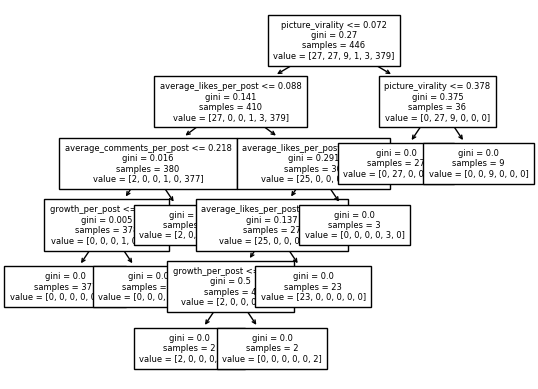

In [ ]:
def surrogate(df, features, clusters):
    classifier = DecisionTreeClassifier(random_state=0)
    classifier.fit(df[features], clusters)
    tree.plot_tree(classifier, fontsize=6, feature_names=features)
    plt.savefig("hjoimichal.png")

print(len(rel_table))
surrogate(rel_table, relevant_features, model.labels_)
    

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

_, model = apply_kmeans_clustering(rel_table, num_clusters=n_clusters)

y = label_binarize(model.labels_, classes = [1,2,3,4,5,6])
clf=RandomForestClassifier()
clf.fit(table, y)


ValueError: Found input variables with inconsistent numbers of samples: [52, 446]

In [ ]:
import shap

explainer = shap.TreeExplainer(clf)

shap_values = explainer(table).values

print(type(shap_values))

if isinstance(shap_values, list):  # Likely a multi-class classification model
    print([np.array(x).shape for x in shap_values])
else:  # For binary classification or regression
    print(np.array(shap_values).shape)
    print("bla")


class_index = 3
shap_values_class = shap_values[:, class_index, :]
print(table.shape)

shap.summary_plot(shap_values_class[:1000, :4], table.iloc[:1000, :4])